In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install gradio

     ---------------------------------------- 0.0/42.9 kB ? eta -:--:--
     ---------------------------------------- 42.9/42.9 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.8 MB ? eta -:--:--
   ---------------------------------------- 0.2/57.8 MB 4.6 MB/s eta 0:00:13
   ---------------------------------------- 0.2/57.8 MB 3.7 MB/s eta 0:00:16
   ---------------------------------------- 0.2/57.8 MB 3.7 MB/s eta 0:00:16
   ---------------------------------------- 0.2/57.8 MB 3.7 MB/s eta 0:00:16
   ---------------------------------------- 0.2/57.8 MB 3.7 MB/s eta 0:00:16
   ---------------------------------------- 0.4/57.8 MB 1.5 MB/s eta 0:00:38
   ---------------------------------------- 0.7/57.8 MB 2.2 MB/s eta 0:00:27
    --------------------------------------- 1.1/57.8 MB 2.7 MB/s eta 0:00:22
    --------------------------------------- 1.4/57.8 MB 3.1 MB/s eta 0:00:18
    --------------------------------------- 1.4/57.8 MB 3.1 MB/s eta 0:00:18
   - ---

In [ ]:
# !pip install torch

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/204.1 MB 3.5 MB/s eta 0:00:59
   ---------------------------------------- 0.5/204.1 MB 5.1 MB/s eta 0:00:41
   ---------------------------------------- 0.8/204.1 MB 5.0 MB/s eta 0:00:41
   ---------------------------------------- 1.1/204.1 MB 5.6 MB/s eta 0:00:37
   ---------------------------------------- 1.5/204.1 MB 6.5 MB/s eta 0:00:32
   ---------------------------------------- 1.8/204.1 MB 6.5 MB/s eta 0:00:32
   ---------------------------------------- 2.3/204.1 MB 6.8 MB/s eta 0:00:30
    --------------------------------------- 2.6/204.1 MB 6.9 MB/s eta 0:00:30
    --------------------------------------- 2.9/204.1 MB 6.5 MB/s eta 0:00:31
    --------------------------------------- 3.2/204.1 MB 6.9 MB/s eta 0:00:30
    --------------------------------------- 3.7/204.1 MB 7.0 MB/s eta 0:00:29
    --------------------------------------- 4.1/204.1 MB 7.0 MB/s eta 0

In [ ]:
# !pip install transformers

  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.2-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)
Using cached safetensors-0.5.2-cp38-abi3-win_amd64.whl (303 kB)
Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl (2.4 MB)



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr
from datetime import datetime
import re
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel

In [3]:
class HierarchicalBotDetector:
    def __init__(self):  # Fixed method name from _init_ to __init__
        # Base level models
        self.scaler = StandardScaler()
        self.behavioral_model = RandomForestClassifier(
            n_estimators=500,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            class_weight='balanced'
        )

        self.tweet_vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=5,
            max_df=0.7,
            stop_words='english'
        )
        self.tweet_model = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight='balanced'
        )

        self.meta_classifier = RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            random_state=42,
            class_weight='balanced'
        )

        self.feature_names = []
        self.models_trained = {'behavioral': False, 'tweet': False, 'meta': False}

    def parse_date(self, date_str):
        """Parse date strings into days since creation"""
        try:
            # Handle common Twitter date format
            date_obj = datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')
        except ValueError:
            try:
                # Handle ISO format
                date_obj = datetime.fromisoformat(date_str.replace('Z', '+00:00'))
            except ValueError:
                # Return a default value if parsing fails
                return 0

        # Calculate days since creation
        days_since = (datetime.now(date_obj.tzinfo) - date_obj).days
        return max(0, days_since)  # Ensure non-negative

    def create_derived_features(self, df):
        """Create derived features from raw data"""
        df = df.copy()

        # Calculate derived ratios and metrics
        df['followers_friends_ratio'] = df['followers_count'] / (df['friends_count'] + 1)

        # Calculate account age if created_at exists
        if 'created_at' in df.columns:
            df['account_age_days'] = df['created_at'].apply(lambda x: self.parse_date(str(x)))
        else:
            df['account_age_days'] = 0

        df['statuses_per_day'] = df['statuses_count'] / (df['account_age_days'] + 1)
        df['engagement_ratio'] = df['favorites_count'] / (df['statuses_count'] + 1)

        # Text-based features
        df['name_length'] = df['name'].str.len()
        df['name_has_digits'] = df['name'].str.contains('\d').astype(int)
        df['description_length'] = df['description'].str.len()
        df['has_location'] = df['location'].str.len().gt(0).astype(int)
        df['has_url'] = df['url'].astype(bool).astype(int)

        # Convert boolean columns to integers
        bool_columns = ['verified', 'default_profile', 'default_profile_image', 'has_extended_profile']
        for col in bool_columns:
            if col in df.columns:
                df[col] = df[col].astype(int)

        return df


    def train_hierarchical_model(self, behavioral_csv, tweet_csv, meta_train_csv=None):
        """
        Train the complete hierarchical model with comprehensive evaluation metrics.
        """
        print("Training Behavioral Model...")
        behavioral_results = self.train_behavioral_model(behavioral_csv)

        print("\nTraining Tweet Content Model...")
        tweet_results = self.train_tweet_model(tweet_csv)

        if meta_train_csv is not None:
            self.train_meta_model(meta_train_csv)
        else:
            print("No meta-training data provided. Using weighted average combination.")


    def train_behavioral_model(self, csv_path):
        """Train the behavioral features model with evaluation metrics"""
        data = self.load_behavioral_data(csv_path)
        df = self.create_derived_features(data)

        feature_columns = [
            'followers_count', 'friends_count', 'listed_count',
            'favorites_count', 'statuses_count', 'verified',
            'followers_friends_ratio', 'statuses_per_day', 'engagement_ratio',
            'account_age_days', 'name_length', 'name_has_digits',
            'description_length', 'has_location', 'has_url',
            'default_profile', 'default_profile_image', 'has_extended_profile'
        ]

        self.feature_names = feature_columns
        X = df[feature_columns]
        y = df['is_bot']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.behavioral_model.fit(X_train_scaled, y_train)
        self.models_trained['behavioral'] = True

        # Model evaluation
        train_accuracy = self.behavioral_model.score(X_train_scaled, y_train)
        test_accuracy = self.behavioral_model.score(X_test_scaled, y_test)

        print("\nBehavioral Model Evaluation:")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Accuracy: {test_accuracy:.4f}")

        y_pred = self.behavioral_model.predict(X_test_scaled)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred, "Behavioral Model")

        # Plot feature importance
        self.plot_feature_importance(self.behavioral_model, "Behavioral Model")

        # Get probabilities for meta-model training
        train_probs = self.behavioral_model.predict_proba(X_train_scaled)
        test_probs = self.behavioral_model.predict_proba(X_test_scaled)

        return {
            'train_data': (X_train_scaled, y_train, train_probs),
            'test_data': (X_test_scaled, y_test, test_probs)
        }


    def train_tweet_model(self, tweets_csv_path):
        """Train the tweet content model with evaluation metrics"""
        tweets_df = pd.read_csv(tweets_csv_path)

        X = self.tweet_vectorizer.fit_transform(tweets_df['Tweet'].fillna(''))
        y = tweets_df['Bot Label']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        self.tweet_model.fit(X_train, y_train)
        self.models_trained['tweet'] = True

        # Model evaluation
        train_accuracy = self.tweet_model.score(X_train, y_train)
        test_accuracy = self.tweet_model.score(X_test, y_test)

        print("\nTweet Model Evaluation:")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Accuracy: {test_accuracy:.4f}")

        y_pred = self.tweet_model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred, "Tweet Model")

        # Get probabilities for meta-model training
        train_probs = self.tweet_model.predict_proba(X_train)
        test_probs = self.tweet_model.predict_proba(X_test)

        return {
            'train_data': (X_train, y_train, train_probs),
            'test_data': (X_test, y_test, test_probs)
        }

    def train_meta_model(self, meta_train_csv):
        """
        Train the meta-classifier using predictions from base models
        """
        print("\nTraining Meta Model...")
        meta_data = pd.read_csv(meta_train_csv)

        # Get predictions from both base models
        behavioral_features = self.prepare_behavioral_features(meta_data)
        behavioral_probs = self.behavioral_model.predict_proba(behavioral_features)

        tweet_features = self.tweet_vectorizer.transform(meta_data['Tweet'].fillna(''))
        tweet_probs = self.tweet_model.predict_proba(tweet_features)

        # Combine predictions for meta-features
        meta_features = np.hstack([behavioral_probs, tweet_probs])

        # Train meta classifier
        X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
            meta_features, meta_data['is_bot'], test_size=0.2, random_state=42
        )

        self.meta_classifier.fit(X_meta_train, y_meta_train)
        self.models_trained['meta'] = True

        # Evaluate meta-model
        meta_predictions = self.meta_classifier.predict(X_meta_test)
        print("\nMeta-Model Performance:")
        print(classification_report(y_meta_test, meta_predictions))

    def predict(self, features=None, tweet=None):
        """Make hierarchical predictions"""
        if not any(self.models_trained.values()):
            raise ValueError("No models have been trained yet")

        predictions = []
        confidences = []

        # Get behavioral predictions if available
        if features is not None and self.models_trained['behavioral']:
            features_scaled = self.scaler.transform(features)
            behavioral_probs = self.behavioral_model.predict_proba(features_scaled)[0]
            predictions.append(behavioral_probs)

        # Get tweet predictions if available
        if tweet is not None and self.models_trained['tweet']:
            tweet_features = self.tweet_vectorizer.transform([tweet])
            tweet_probs = self.tweet_model.predict_proba(tweet_features)[0]
            predictions.append(tweet_probs)

        # Use meta-classifier if available and both predictions exist
        if self.models_trained['meta'] and len(predictions) == 2:
            meta_features = np.hstack(predictions).reshape(1, -1)
            final_probs = self.meta_classifier.predict_proba(meta_features)[0]
            prediction = (final_probs[1] > 0.5)
            confidence = final_probs[1] if prediction else final_probs[0]
        else:
            # Use weighted average if meta-classifier isn't available
            weights = [0.6, 0.4] if len(predictions) == 2 else [1.0]
            final_probs = np.average(predictions, weights=weights, axis=0)
            prediction = (final_probs[1] > 0.5)
            confidence = final_probs[1] if prediction else final_probs[0]

        return prediction, confidence

    def load_behavioral_data(self, csv_path):
        """Load and preprocess behavioral data"""
        try:
            df = pd.read_csv(csv_path)

            # Drop standard unnecessary columns if they exist
            columns_to_drop = ['id', 'id_str', 'screen_name', 'lang', 'status']
            df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

            # Fill missing values
            df['url'] = df['url'].fillna(False)
            df['location'] = df['location'].fillna('')
            df['description'] = df['description'].fillna('')
            df['name'] = df['name'].fillna('')

            # Rename columns if needed
            column_mapping = {
                'listedcount': 'listed_count',
                'favourites_count': 'favorites_count',
                'bot': 'is_bot'
            }
            df = df.rename(columns=column_mapping, errors='ignore')

            # Fill numeric columns
            numeric_cols = ['followers_count', 'friends_count', 'listed_count',
                          'favorites_count', 'statuses_count']
            df[numeric_cols] = df[numeric_cols].fillna(0)

            # Convert boolean columns
            bool_cols = ['verified', 'default_profile', 'default_profile_image',
                        'has_extended_profile']
            for col in bool_cols:
                if col in df.columns:
                    df[col] = df[col].fillna(False).astype(bool)

            print(f"Loaded dataset with {len(df)} rows and columns: {', '.join(df.columns)}")
            return df

        except Exception as e:
            print(f"Error loading data: {str(e)}")
            print("Available columns in CSV:", pd.read_csv(csv_path).columns.tolist())
            raise



    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Generate and display a styled confusion matrix heatmap"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Human', 'Bot'],
            yticklabels=['Human', 'Bot']
        )
        plt.title(f'Confusion Matrix - {model_name}', pad=20)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, model_name):
        """Display and plot feature importance rankings"""
        importance = model.feature_importances_

        fi_df = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        print(f"\n{model_name} Feature Importance Rankings:")
        pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
        print(fi_df.to_string(index=False))

        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='Importance',
            y='Feature',
            data=fi_df,
            palette='viridis'
        )
        plt.title(f'Feature Importance - {model_name}', pad=20)
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    def create_gradio_interface(self):
        def predict_account(*args, tweet=None):
            features = None
            if len(args) > 0:  # If behavioral features are provided
                features = pd.DataFrame([{
                    'followers_count': args[3],
                    'friends_count': args[4],
                    'listed_count': args[5],
                    'favorites_count': args[6],
                    'statuses_count': args[7],
                    'verified': int(args[9]),
                    'followers_friends_ratio': args[3] / (args[4] + 1),
                    'statuses_per_day': args[7] / (args[8] + 1),
                    'engagement_ratio': args[6] / (args[7] + 1),
                    'account_age_days': args[8],
                    'name_length': len(args[0]),
                    'name_has_digits': int(bool(re.search(r'\d', args[0]))),
                    'description_length': len(args[1]),
                    'has_location': int(bool(args[2].strip())),
                    'has_url': int(args[13]),
                    'default_profile': int(args[10]),
                    'default_profile_image': int(args[11]),
                    'has_extended_profile': int(args[12])
                }])

            try:
                prediction, confidence = self.predict(features, tweet)
                result = "🤖 Bot Account" if prediction else "👤 Human Account"
                return f"{result} (Confidence: {confidence*100:.1f}%)"
            except ValueError as e:
                return str(e)

        interface = gr.Interface(
            fn=predict_account,
            inputs=[
                gr.Textbox(label="Account Name"),
                gr.Textbox(label="Profile Description"),
                gr.Textbox(label="Location"),
                gr.Number(label="Followers Count", minimum=0),
                gr.Number(label="Friends Count", minimum=0),
                gr.Number(label="Listed Count", minimum=0),
                gr.Number(label="Favorites Count", minimum=0),
                gr.Number(label="Statuses Count", minimum=0),
                gr.Number(label="Account Age (days)", minimum=0),
                gr.Checkbox(label="Verified Account"),
                gr.Checkbox(label="Default Profile"),
                gr.Checkbox(label="Default Profile Image"),
                gr.Checkbox(label="Has Extended Profile"),
                gr.Checkbox(label="Has URL in Profile"),
                gr.Textbox(label="Tweet Content (Optional)")
            ],
            outputs=gr.Label(label="Prediction"),
            title="Dual Bot Detection System",
            description="Detects bots using both account characteristics and tweet content analysis.",
            examples=[
                ["NewsBot2023", "Automated news updates", "Global",
                 50000, 10, 5, 100, 10000, 30, False, True, True, False, False,
                 "Breaking: Latest headlines from around the world! Click here for more..."],
                ["JohnSmith", "Digital artist and nature lover", "New York",
                 1500, 800, 12, 3500, 500, 730, True, False, False, True, True,
                 "Just finished my latest artwork inspired by Central Park in autumn!"]
            ]
        )
        return interface


<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_23044\2236276863.py:72: SyntaxWarning: invalid escape sequence '\d'
  df['name_has_digits'] = df['name'].str.contains('\d').astype(int)


Training Behavioral Model...
Loaded dataset with 1562 rows and columns: location, description, url, followers_count, friends_count, listed_count, created_at, favorites_count, verified, statuses_count, default_profile, default_profile_image, has_extended_profile, name, is_bot


C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_23044\2236276863.py:294: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)



Behavioral Model Evaluation:
Training Accuracy: 0.9263
Testing Accuracy: 0.8690

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       164
           1       0.89      0.83      0.86       149

    accuracy                           0.87       313
   macro avg       0.87      0.87      0.87       313
weighted avg       0.87      0.87      0.87       313



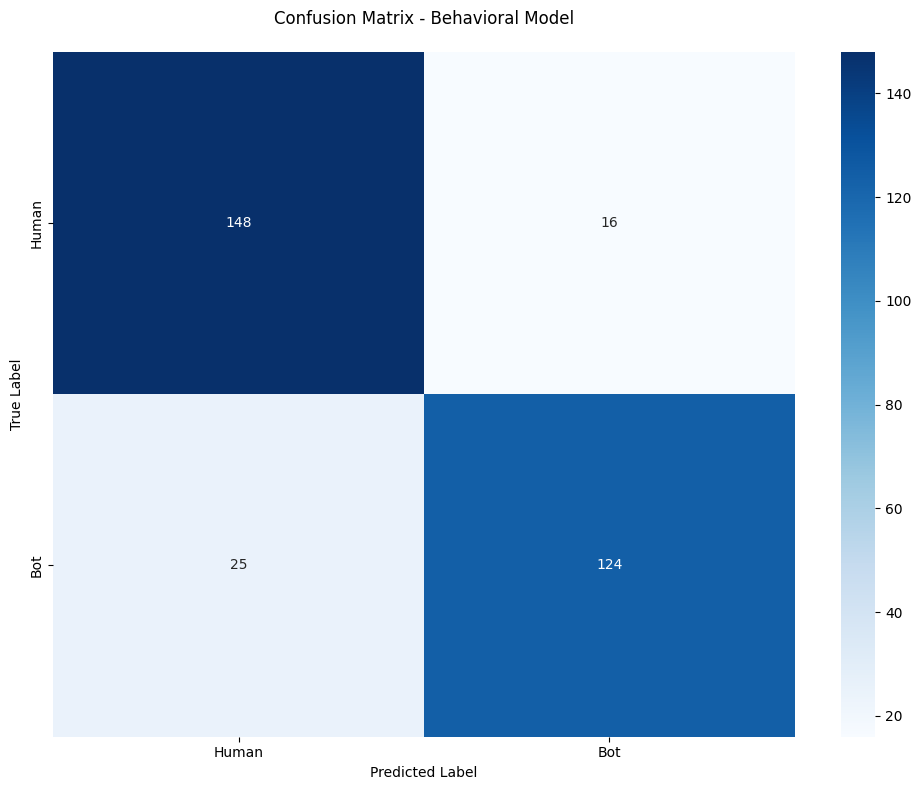


Behavioral Model Feature Importance Rankings:
                Feature  Importance
          friends_count    0.219933
followers_friends_ratio    0.121446
       account_age_days    0.109488
               verified    0.094301
        favorites_count    0.092454
       engagement_ratio    0.089416
        followers_count    0.085259
           listed_count    0.052153
        default_profile    0.040293
         statuses_count    0.036331
       statuses_per_day    0.028321
     description_length    0.010794
            name_length    0.006377
   has_extended_profile    0.004665
           has_location    0.003732
                has_url    0.003058
        name_has_digits    0.001077
  default_profile_image    0.000902


C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_23044\2236276863.py:338: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


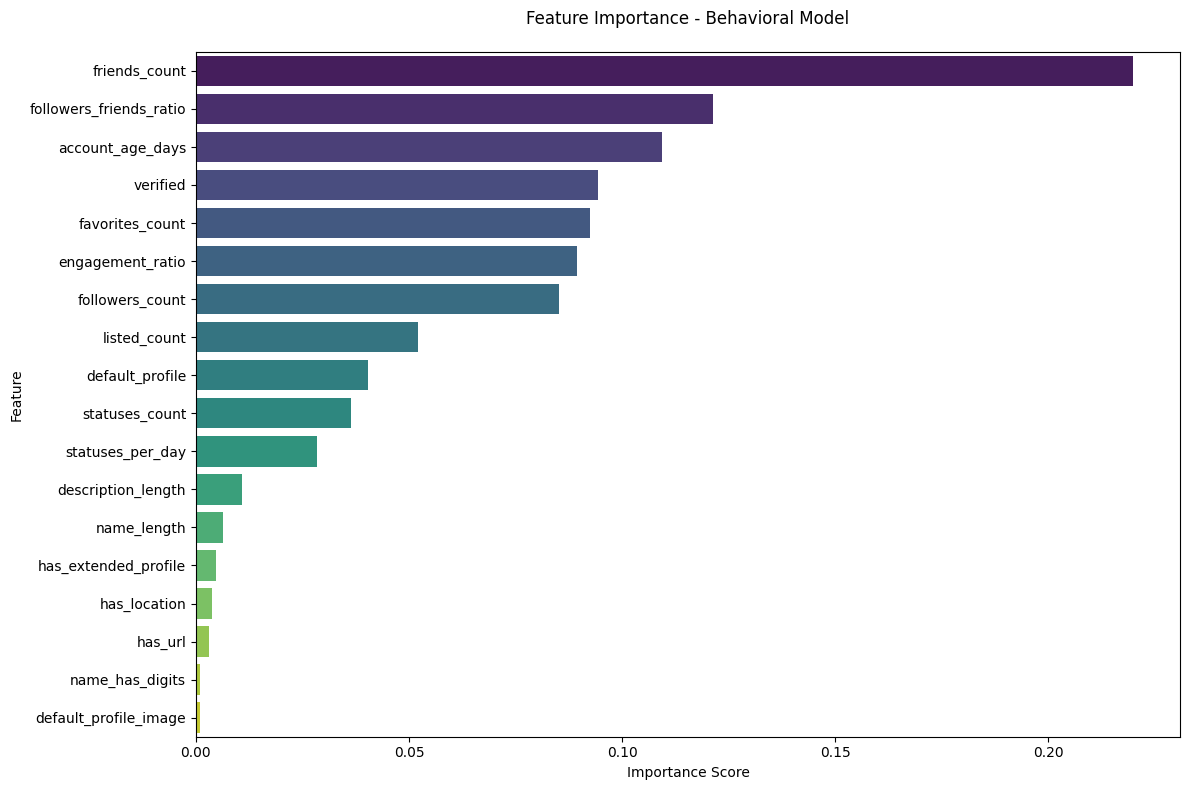


Training Tweet Content Model...

Tweet Model Evaluation:
Training Accuracy: 1.0000
Testing Accuracy: 0.4978

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      4996
           1       0.50      0.48      0.49      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



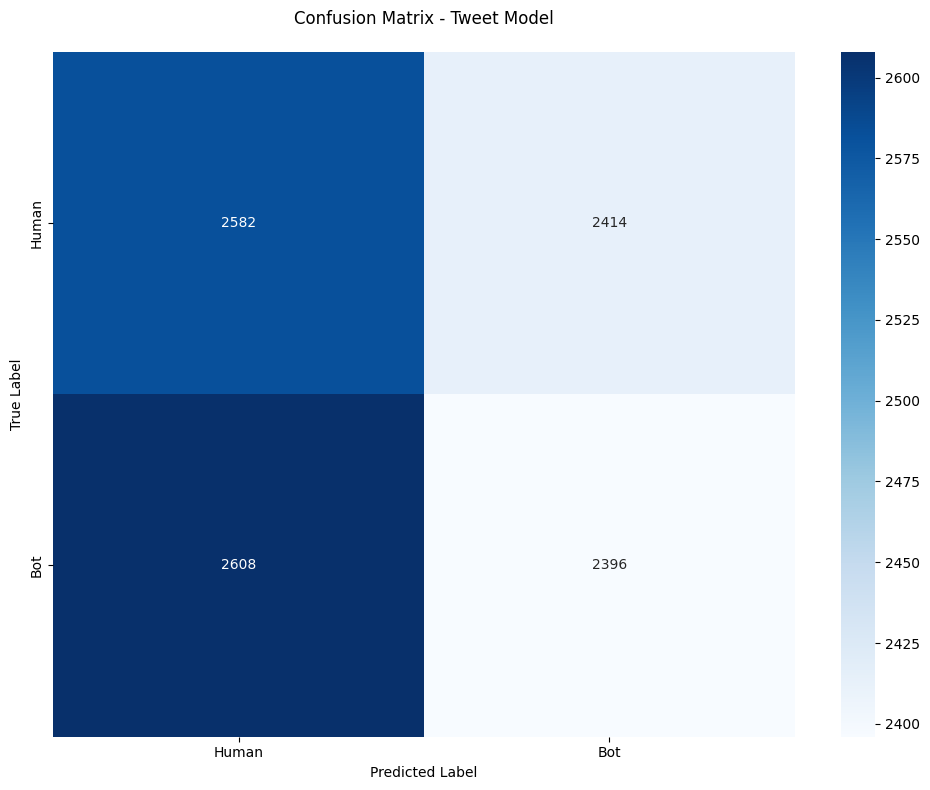

No meta-training data provided. Using weighted average combination.
* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [4]:
if __name__ == "__main__":

    detector = HierarchicalBotDetector()

    detector.train_hierarchical_model(
    behavioral_csv="../Dataset/training_data.csv",
    tweet_csv="../Dataset/bot_detection_data.csv"
    )



    # Create and launch the interface
    iface = detector.create_gradio_interface()
    iface.launch(share=True)